In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Comparing LSA, LDA, and NNMF
We're going to try 3 different extraction methods on the Emma corpus. We'll be looking at interpretability, speed, and consistency across methods. The goal is to identify common themes in Emma on a per-paragraph basis. We won't be using pLSA as sklearn does not support it.

To do this, we will:
   * Parse and process the data into a tf-idf matrix.
   * Fit LSA, LDA, and NNMF models with 5 topics each.
   * Extract the words that best describe each topic.
   * Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'
   
Let's get started!

### Generating the tfidf matrix

In [2]:
# Processing the data.
from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Reading in the data in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')

# Processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0] 
    para=[re.sub(r'--','',word) for word in para] #removing the double-dash from all words
    emma_paras.append(' '.join(para)) #forming each paragraph into a string and adding it to the list of strings.

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Print out the first 20 features:
terms[:21]

['000',
 '10',
 '1816',
 '23rd',
 '24th',
 '8th',
 '_accepted_',
 '_amor_',
 '_as_',
 '_been_',
 '_bride_',
 '_broke_',
 '_court_',
 '_doubts_',
 '_eighteen_',
 '_first_',
 '_has_',
 '_have_',
 '_he_',
 '_her_',
 '_him_']

In [3]:
# Create utility fuctions to extract words:
# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    words_by_topic=tfidf.T * solution # Loading scores for each word on each topic/component.
    components=pd.DataFrame(words_by_topic,index=wordlist) # Linking the loadings to the words in an easy-to-read way. 
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):      
        sortedwords=components.iloc[:,column].sort_values(ascending=False) #Sort the column so that highest loadings are at the top.
        chosen=sortedwords[:n_top_words] #Choose the N highest loadings.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) #Combine loading and index into a string.
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

### Fitting the three topic extraction models

In [4]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [9]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

In [10]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

### Inspecting the topics
For each topic, we list the ten most-relevant words according to each method:

In [11]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
               LSA             NNMF            LDA
0         oh 97.61         oh 30.12      emma 13.3
0         yes 4.79         yes 0.52  harriet 12.73
0  difference 1.58       sorry 0.16        mr 11.6
0       thank 1.46  difference 0.15      said 10.2
0        just 1.44        just 0.12        oh 9.99
0     harriet 1.32        papa 0.12     think 9.48
0       sorry 1.28        week 0.11       mrs 9.13
0       short 1.18       short 0.11   chapter 8.69
0        papa 1.14    recollect 0.1     quite 7.79
0       cried 1.02      letter 0.09      miss 7.12
Topic 1:
             LSA            NNMF           LDA
1       mr 58.11         mr 7.29      oh 58.31
1     emma 58.06        mrs 4.26     emma 19.1
1     said 50.31      elton 3.41    said 14.64
1      mrs 47.04  knightley 3.24     mrs 14.23
1     miss 37.74     weston 3.15      mr 14.19
1  harriet 34.65       miss 2.99     yes 13.91
1    weston 32.2  woodhouse 2.09     did 10.73
1    elton 27.82       said 1.88     miss 9.5

### Sparsity
Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

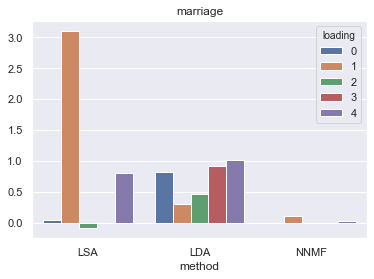

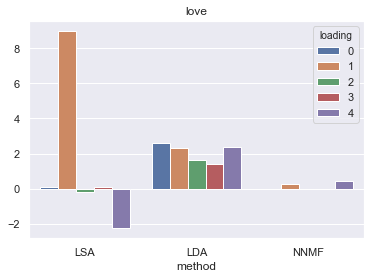

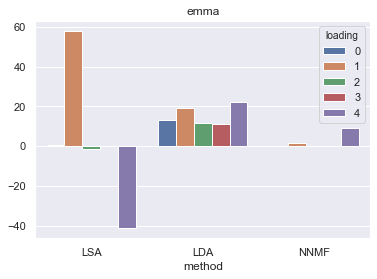

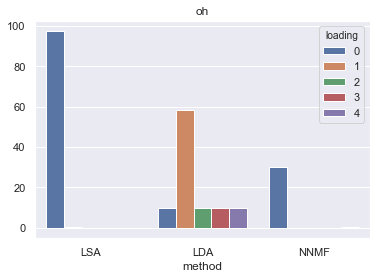

In [13]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()



LSA is the method most likely to have high loadings on more than one topic for the same word. LDA tends to have one high loading and some lower loadings. Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.